In [1]:
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import os
from scipy import special, stats
from scipy.stats import pearsonr
from bisect import bisect_left
import functools
%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 16})

## Распределение Ципфа (дискретное)

### 1.1 Выбор распределения
Параметры: 
- $s\geq 0$ - вещественное число
- $N\in\mathbb{N}$

Распределение задано на $\mathbb{N}$

$\mathbb{P}\{\xi=k\}=\dfrac{k^{-s}}{\sum\limits_{n=1}^{N}n^{-s}}$


### 1.2 Описание основных характеристик распределения
Посчитаем **математическое ожидание** случайной величины $\xi$, имеющей распределение Ципфа:

$\mathbb{E}\xi=
\sum\limits_{k=1}^{N}\left[k\cdot\dfrac{k^{-s}}{\sum\limits_{n=1}^{N}n^{-s}}\right]=
\dfrac{\sum\limits_{k=1}^{N}k^{1-s}}{\sum\limits_{n=1}^{N}n^{-s}};$

$\lim\limits_{N\to\infty}\mathbb{E}\xi=\dfrac{\zeta(s-1)}{\zeta(s)}$

Посчитаем **дисперсию** $\xi$:

$\mathbb{E}\left(\xi^2\right)=
\sum\limits_{k=1}^{N}\left[k^2\cdot\dfrac{k^{-s}}{\sum\limits_{n=1}^{N}n^{-s}}\right]=
\dfrac{\sum\limits_{k=1}^{N}k^{2-s}}{\sum\limits_{n=1}^{N}n^{-s}}$

$\mathbb{D}\xi=
\mathbb{E}\left(\xi^2\right)-\left(\mathbb{E}\xi\right)^2=
\dfrac{\sum\limits_{k=1}^{N}k^{2-s}}{\sum\limits_{n=1}^{N}n^{-s}}-\left[\dfrac{\sum\limits_{k=1}^{N}k^{1-s}}{\sum\limits_{n=1}^{N}n^{-s}}\right]^2$

$\lim\limits_{N\to\infty}\mathbb{D}\xi=
\dfrac{\zeta(s-2)}{\zeta(s)}-\dfrac{\zeta^{2}(s-1)}{\zeta^{2}(s)}=
\zeta^{-2}(s)\left(\zeta(s-2)\zeta(s)-\zeta^{2}(s-1)\right)$

Посчитаем **производящую функцию** $\xi$:

$\varphi(z)=\mathbb{E}\left(z^\xi\right)=
\sum\limits_{k=1}^{N}\left[\dfrac{k^{-s}}{\sum\limits_{n=1}^{N}n^{-s}}z^k\right]=
\dfrac{\sum\limits_{k=1}^{N} k^{-s}z^k}{\sum\limits_{n=1}^{N}n^{-s}}$

Посчитаем **характеристическую функцию** $\xi$:

$\phi(z)=\mathbb{E}\left(e^{iz\xi}\right)=
\sum\limits_{k=1}^{N}\left[\dfrac{k^{-s}}{\sum\limits_{n=1}^{N}n^{-s}}e^{izk}\right]=
\dfrac{\sum\limits_{k=1}^{N} k^{-s}e^{izk}}{\sum\limits_{n=1}^{N}n^{-s}}$

In [3]:
# функция вероятности
def zipf_pmf(x, s, N): return (1 / x**s) / sum([1 / n**s for n in range(1, N+1)])
# функция распределения
def zipf_cdf(x, s, N):
    ret = np.zeros(x.shape)
    for i in range(x.shape[0]):
        ret[i] += np.sum(zipf_pmf(np.arange(1, np.floor(x[i])+1), s, N))
    return ret

#### Гистограмма вероятностей

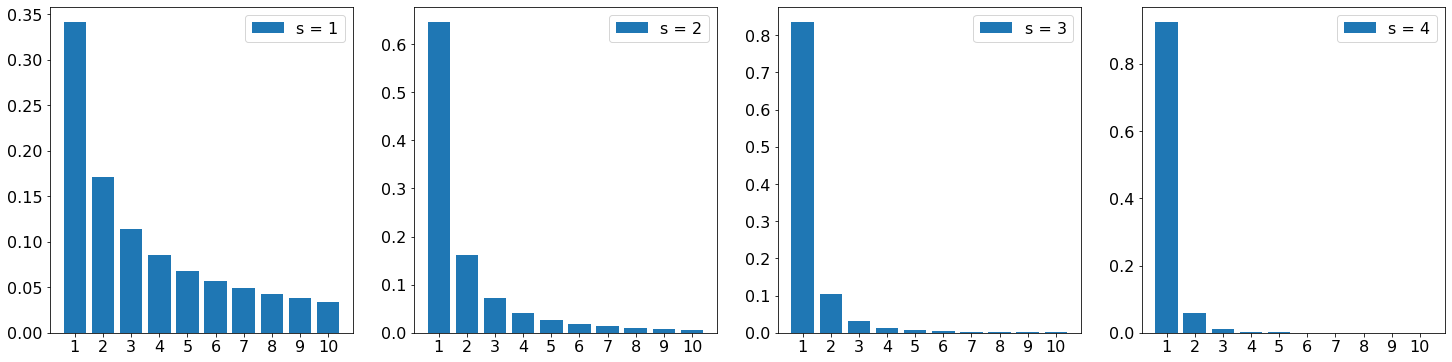

In [4]:
x = np.arange(1, 11)
plt.figure(figsize=(25, 6))
for param, pos in zip([1, 2, 3, 4], [141, 142, 143, 144]):
    plt.subplot(pos)
    plt.xticks(range(1, 11))
    plt.bar(x, zipf_pmf(x, s=param, N=10), label="s = {}".format(param))
    plt.legend()

#### График функции распределения

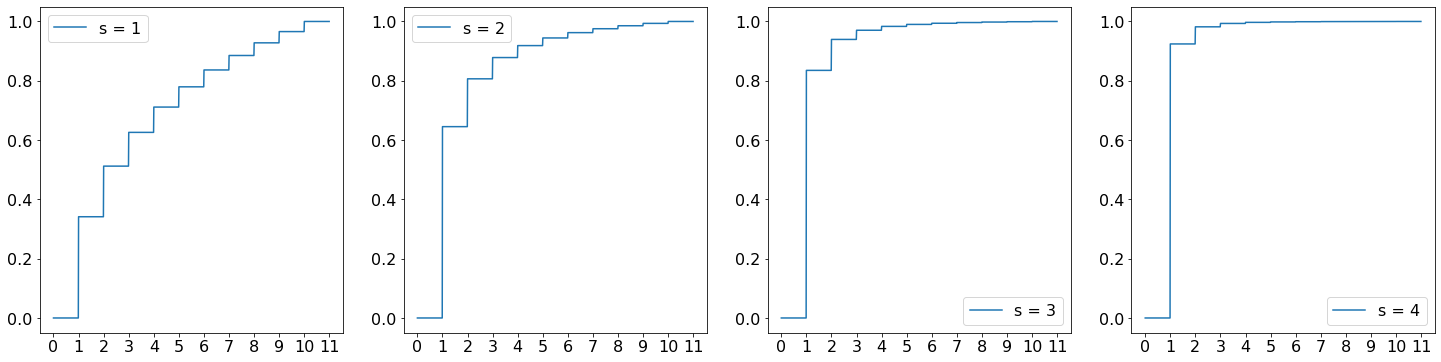

In [5]:
x = np.arange(0, 11, 0.01)
plt.figure(figsize=(25, 6))
for param, pos in zip([1, 2, 3, 4], [141, 142, 143, 144]):
    plt.subplot(pos)
    plt.xticks(range(0, 12))
    plt.plot(x, zipf_cdf(x, s=param, N=10), label="s = {}".format(param))
    plt.legend()

### 1.3 Поиск примеров событий, которые могут быть описаны выбранными случайными величинами
Пусть задан текст на естественном языке. Посчитаем количество уникальных слов в нем, и для каждого слова определим, сколько раз оно встречается в тексте. Таким образом, получится, что какие-то слова встречаются 1 раз, какие-то 2 раза и т.д., пусть максимальное количество вхождений слова равно $N$. Количество вхождений слова в текст будем называть рангом этого слова. Утверждается, что распределение Ципфа с параметром $N$ и некоторым $s$ описывает вероятность того, случайно выбранное из текста слово имеет ранг $k$.

На примере текста книги "Война и мир" Л. Н. Толстого покажем, что распределение Ципфа действительно можно интерпретировать таким образом. Текст возьмем на английском языке, т.к. в нем у одного слова может быть не так много форм, как в русском языке.

In [6]:
with open('warandpeace.txt', 'r') as book:
    data = book.read()
words = data.lower().split()
word_counts = dict()
for word in words:
    if word in word_counts:
        word_counts[word] += 1
    else:
        word_counts[word] = 1
word_counts = np.array(list(word_counts.values()))
# freqs[i] - количество слов с рангом (i + 1)
freqs = np.array([0] * max(word_counts))
for word_count in word_counts:
    freqs[word_count - 1] += 1
freqs = freqs / np.sum(freqs)

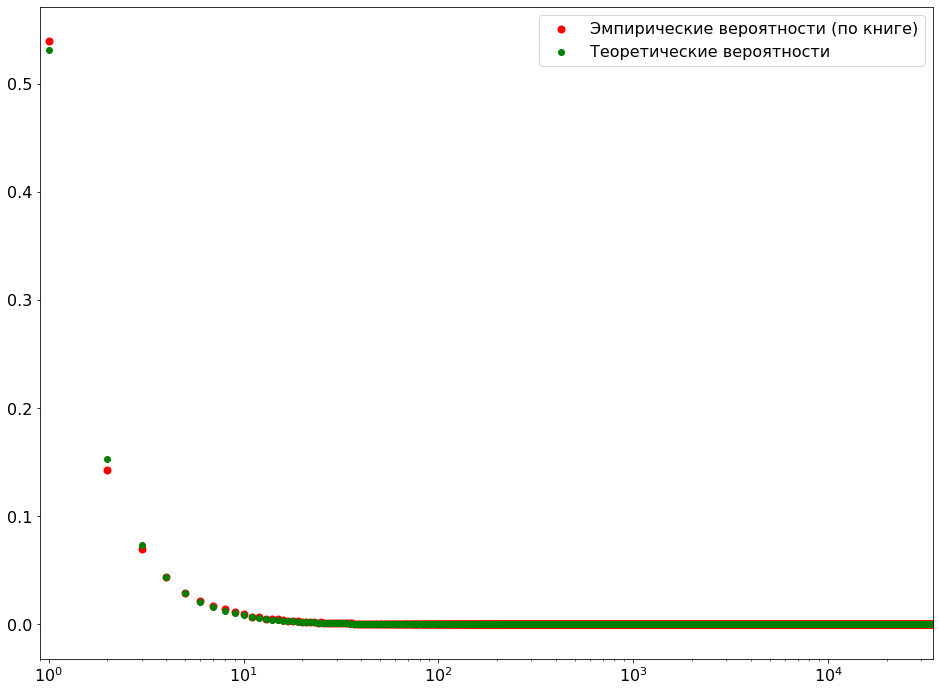

In [7]:
_, ax = plt.subplots(figsize=(16, 12))
ax.set_xscale("log")
ax.set_xlim(0.9, len(freqs))
x_values = np.arange(1, len(freqs) + 1)
plt.scatter(x_values, freqs, linewidth=2, color='r', label="Эмпирические вероятности (по книге)")
plt.scatter(x_values, zipf_pmf(x_values, 1.8, len(word_counts)), color='g', label="Теоретические вероятности")
plt.legend()
plt.show()

### 1.4 Описание способа моделирования выбранных случайных величин

Дискретные случайные величины легко моделируются с использованием равномерно распределенной на $[0, 1]$ случайной величины. Рассмотрим конкретнее на примере распределения Ципфа.

Пусть необходимо смоделировать случайную величину $\xi$, распределение которой имеет вид распределения Ципфа с параметрами $s$ и $N$. $\xi$ принимает значения $1,2,\ldots,N$.
Обозначим $d_i=\sum\limits_{k=1}^{i}\mathbb{P}\left(\xi=k\right), d_0=0$. Пусть генератор случайных чисел выдал некоторое число $l\in[0,1)$. Тогда в качестве значения $\xi$ возьмем такое $i$, что $d_{i-1}\leq l<d_i$. Такой способ моделирования случайной величины корректен, т.к. длины отрезков $[d_{i-1},d_i]$ равны $\mathbb{P}\left(\xi=i\right)$ (по построению)

Код, реализующий данный алгоритм генерации и строящий графики с теоретическими и эмпирическими вероятностями (для визуального сравнения), приведен ниже.

In [8]:
def zipf_random(s, N, size=1):
    uni_random = stats.uniform.rvs(size=size)
    ticks = [0]
    ret = []
    for elem in uni_random:
        if elem <= ticks[-1]:
            ret.append(bisect_left(ticks, elem))
        else:
            cur = len(ticks)
            while ticks[-1] < elem:
                ticks.append(ticks[-1] + zipf_pmf(cur, s, N))
                cur += 1
            ret.append(cur - 1)
    return ret

In [9]:
def draw_generated_zipf(s, N, size):
    zipf_generated = zipf_random(s, N, size)
    freqs = np.array([0] * N)
    for elem in zipf_generated:
        freqs[elem - 1] += 1
    freqs = freqs / sum(freqs)
    x_values = np.arange(1, N+1)
    plt.figure(figsize=(16, 12))
    plt.scatter(x_values, freqs, linewidth=2, color='r', label="Эмпирические вероятности")
    plt.scatter(x_values, zipf_pmf(x_values, s, N), color='g', label="Теоретические вероятности")
    plt.legend()
    plt.show()

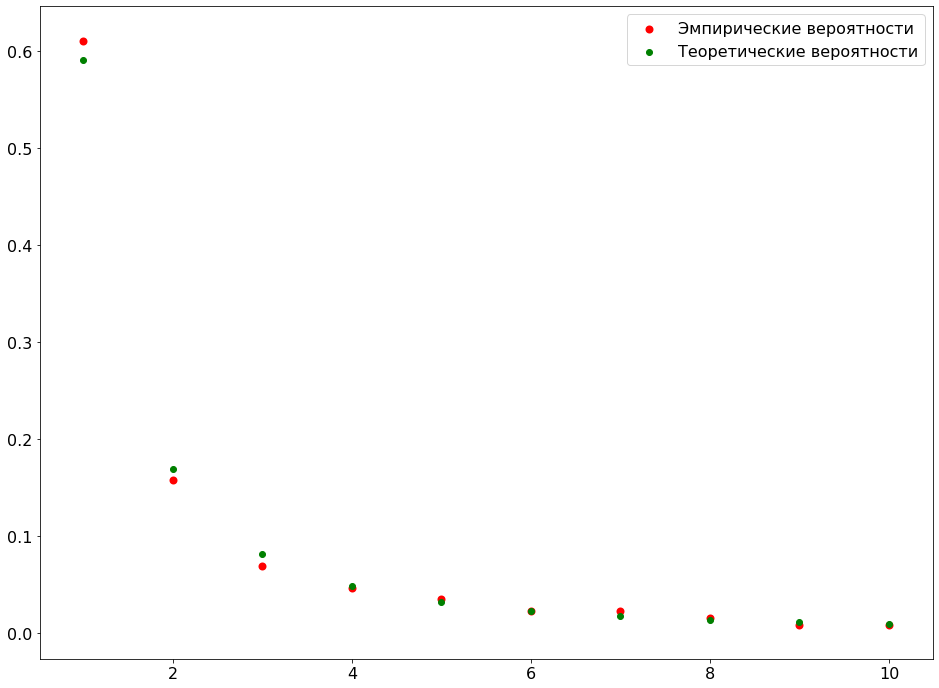

In [10]:
draw_generated_zipf(s=1.8, N=10, size=1000)

## Бета-распределение (абсолютно непрерывное)
### 1.1 Выбор распределения
Параметры: $\alpha, \beta>0$

Распределение задано на отрезке $[0, 1]$

Плотность распределения $f(x)=\dfrac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha,\beta)}$

Функция распределения $F(x)=\dfrac{\int\limits_{0}^{x}t^{\alpha-1}(1-t)^{\beta-1}\ dt}{B(\alpha,\beta)}$

### 1.2 Описание основных характеристик распределения
Посчитаем **математическое ожидание** случайной величины $\xi$, имеющей бета-распределение:

$\displaystyle
\mathbb{E}\xi=
\int\limits_{0}^{1}x\cdot f(x)\ dx=
\dfrac{\int\limits_{0}^{1}x^{\alpha}(1-x)^{\beta-1}\ dx}{B(\alpha,\beta)}=
\dfrac{B(\alpha+1,\beta)}{B(\alpha,\beta)}=
\dfrac{\alpha}{\alpha+\beta}$

Посчитаем **дисперсию** $\xi$:

$\displaystyle
\mathbb{E}\left(\xi^2\right)=
\int\limits_{0}^{1}x^2\cdot f(x)\ dx=
\dfrac{\int\limits_{0}^{1}x^{\alpha+1}(1-x)^{\beta-1}\ dx}{B(\alpha,\beta)}=
\dfrac{B(\alpha+2,\beta)}{B(\alpha,\beta)}=
\dfrac{\alpha}{\alpha+\beta}\cdot\dfrac{\alpha+1}{\alpha+\beta+1}=
\dfrac{\alpha(\alpha+1)}{(\alpha+\beta)(\alpha+\beta+1)}$

$\displaystyle
\mathbb{D}\xi=
\mathbb{E}\left(\xi^2\right)-\left(\mathbb{E}\xi\right)^2=
\dfrac{\alpha(\alpha+1)}{(\alpha+\beta)(\alpha+\beta+1)}-\left[\dfrac{\alpha}{\alpha+\beta}\right]^2=
\dfrac{\alpha(\alpha+1)(\alpha+\beta)-\alpha^2(\alpha+\beta+1)}{(\alpha+\beta)^2(\alpha+\beta+1)}=
\dfrac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}$

Посчитаем **характеристическую функцию** $\xi$:

$\displaystyle
\phi(z)=\mathbb{E}\left(e^{iz\xi}\right)=
\int\limits_{0}^{1}\dfrac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha,\beta)}e^{izx}\ dx=
\dfrac{1}{B(\alpha,\beta)}\int\limits_{0}^{1}x^{\alpha-1}(1-x)^{\beta-1}e^{izx}\ dx$

#### График плотности распределения

In [11]:
# плотность вероятности
def beta_pdf(x, alpha, beta): return stats.beta.pdf(x, alpha, beta)
# функция распределения
def beta_cdf(x, alpha, beta): return special.betainc(alpha, beta, x)

In [12]:
x = np.arange(0, 1, 0.001)
params = [
    {"alpha": 0.7, "beta": 0.7},
    {"alpha": 5, "beta": 1},
    {"alpha": 1, "beta": 3},
    {"alpha": 2, "beta": 5}
]

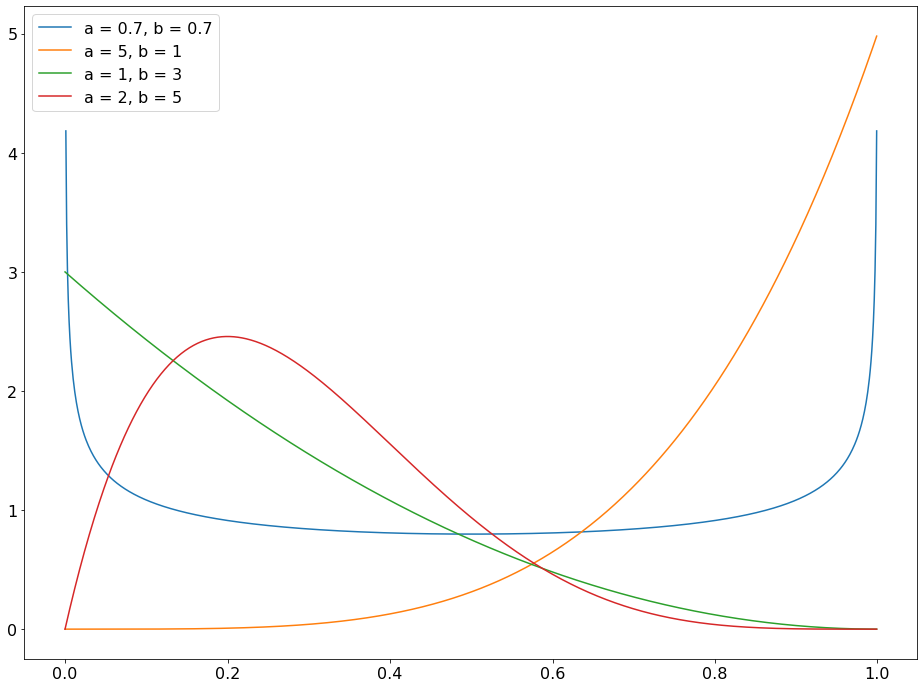

In [13]:
plt.figure(figsize=(16, 12))
for param in params:
    plt.plot(x, beta_pdf(x, param["alpha"], param["beta"]), label="a = {}, b = {}".format(param["alpha"], param["beta"]))
    plt.legend()

#### График функции распределения

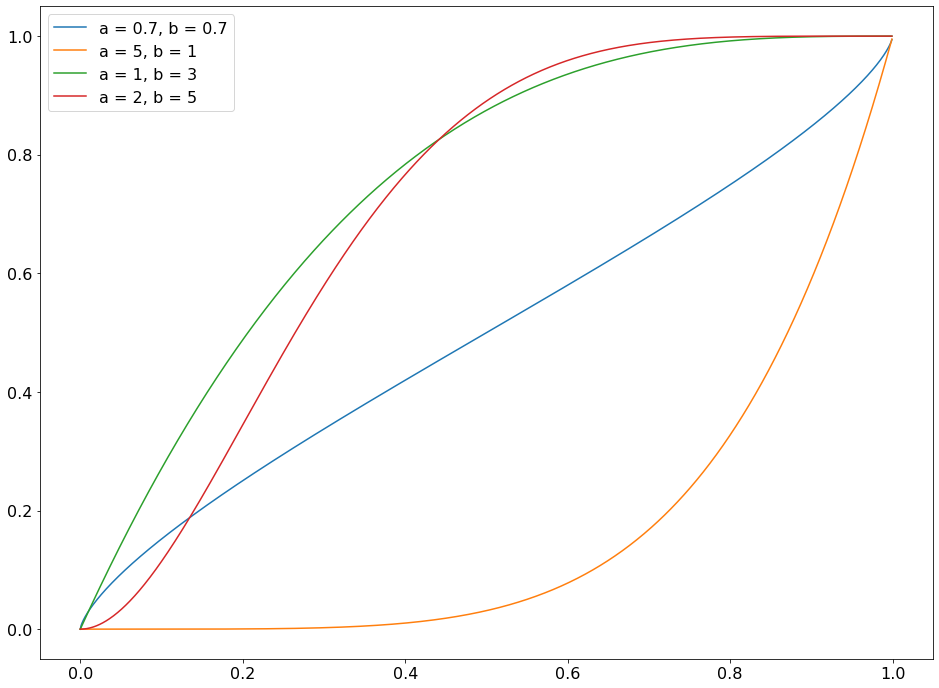

In [14]:
plt.figure(figsize=(16, 12))
for param in params:
    plt.plot(x, beta_cdf(x, param["alpha"], param["beta"]), label="a = {}, b = {}".format(param["alpha"], param["beta"]))
    plt.legend()

### 1.3 Поиск примеров событий, которые могут быть описаны выбранными случайными величинами
#### Типичная интерпретация
Типичной интерпретацией бета-распределения с натуральными параметрами $\alpha$ и $\beta$ является распределение $\alpha$-й порядковой статистики в наборе из $\alpha+\beta-1$ независимых равномерно распределенных на $[0,1]$ случайных величин. О том, почему это так, написано в пункте "1.4 Описание способа моделирования выбранных случайных величин".
#### Нетипичная интерпретация
При анализе данных об астероидах и других малых телах, которые предоставлены Lowell Observatory [1], оказалось, что эксцентриситет орбиты этих тел имеет распределение, близкое к бета-распределению. Код, извлекающий нужные данные и строящий графики эмпирической и теоретической функций распределения, приведен ниже. Вместе с данными по эксцентриситету орбит выбраны и данные по диаметру тел, но из-за их малого объема они не представляют такого большого интереса.

In [15]:
DIAMETER_INFO_CVS_PATH = 'diameter.csv'
ECCENTRICITY_INFO_CVS_PATH = 'eccentricity.csv'

In [16]:
def load_info(source_file, diameter_info=None, eccentricity_info=None):
    def append_to(where, values):
        where.loc[len(where)] = values
    with open(source_file, 'r') as f:
        for line in tqdm.tqdm_notebook(f):
            name = line[7:26].strip()
            if diameter_info is not None:
                diameter = line[59:65].strip()
                if diameter != '':
                    append_to(diameter_info, [name, float(diameter)])
            if eccentricity_info is not None:
                eccentricity = line[159:169].strip()
                if eccentricity != '':
                    append_to(eccentricity_info, [name, float(eccentricity)])

In [17]:
need_diameter = not os.path.isfile(DIAMETER_INFO_CVS_PATH)
need_eccentricity = not os.path.isfile(ECCENTRICITY_INFO_CVS_PATH)
diameter_info, eccentricity_info = (None, None)
if need_diameter:
    diameter_info = pd.DataFrame(columns=['Name', 'Diameter'])
if need_eccentricity:
    eccentricity_info = pd.DataFrame(columns=['Name', 'Eccentricity'])

In [18]:
if need_diameter or need_eccentricity:
    load_info(source_file='astorb.dat', diameter_info=diameter_info, eccentricity_info=eccentricity_info)
if need_diameter:
    with open(DIAMETER_INFO_CVS_PATH, 'w') as out:
        diameter_info.to_csv(out, index=False)
if need_eccentricity:
    with open(ECCENTRICITY_INFO_CVS_PATH, 'w') as out:
        eccentricity_info.to_csv(out, index=False)

In [19]:
d_info = pd.read_csv(DIAMETER_INFO_CVS_PATH)
d_values = np.sort(d_info["Diameter"])
e_info = pd.read_csv(ECCENTRICITY_INFO_CVS_PATH)
e_values = np.sort(e_info["Eccentricity"])

In [20]:
d_values.shape

(2140,)

In [21]:
e_values.shape

(796787,)

In [22]:
# вывод графика эмпирической ф-ии распределения
def draw_edf(empirical_data, minimum, maximum, label='Эмпирическая функция распределения', color='green'):
    plt.hist(empirical_data, len(empirical_data), density=True, histtype='step', color=color, cumulative=True, label=label, linewidth=2)
    plt.hist([empirical_data[-1], maximum], weights=[1, 1], histtype='step', label=None, edgecolor='white', linewidth=2)
    plt.plot([minimum, empirical_data[0]], [0, 0], color=color)
    plt.plot([empirical_data[-1], maximum], [1, 1], color=color)

C:\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


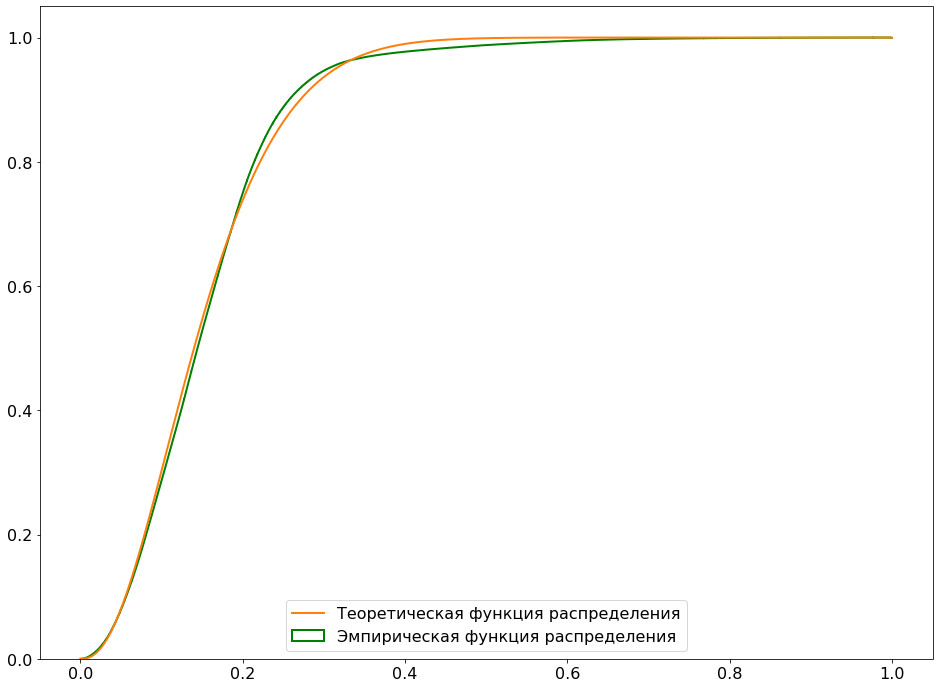

In [23]:
plt.figure(figsize=(16, 12))
draw_edf(e_values, minimum=0, maximum=1)
x_ticks = np.linspace(0, 1, max(1000, len(e_values)))
plt.plot(x_ticks, beta_cdf(x_ticks, alpha=2.6, beta=14.3), linewidth=2, label='Теоретическая функция распределения')
plt.legend()
plt.show()

### 1.4 Описание способа моделирования выбранных случайных величин

Рассмотрим частный случай, когда оба параметра $\alpha$ и $\beta$ являются натуральными числами. В этом случае обозначим $l=\alpha,\ k=\alpha+\beta-1,\ 1\leq l\leq k$ и сгенерируем $k$ чисел, равномерно и независимо распределенных на $[0,1]$. Утверждается, что при таких операциях $l$-я порядковая статистика генерируемого набора чисел будет иметь бета-распределение.

Покажем это, получив функцию распределения $l$-й порядковой статистики, равной функции распределения случайной величины, имеющей бета-распределение. Итак, пусть есть $k=\alpha+\beta-1$ независимых равномерно распределенных случайных величин, пусть вариационный ряд выборки $\left(x_{(1)},x_{(2)},\ldots,x_{(k)}\right)$. Рассмотрим $\Phi(z)=\mathbb{P}\left(x_{(l)}<z\right)$. Событие $x_{(l)}<z$ означает, что как минимум $l$ из $k$ случайных величин оказались меньше $z$, про остальные ничего не известно. Очевидно, что $\mathbb{P}\left(x_{(i)}<z\right)=z$, $\mathbb{P}\left(x_{(i)}\geq z\right)=1-z$. Отсюда имеем:

$\displaystyle
\Phi(z)=\mathbb{P}\left(x_{(l)}<z\right)=
\sum\limits_{i=l}^{k}C_k^i z^i (1-z)^{k-i}$

Интегрированием по частям можно показать, что $\displaystyle\int_{0}^{z}\dfrac{t^{l-1}(1-t)^{k-l}}{B(l,k+1-l)}\ dt=\sum\limits_{i=l}^{k}C_k^i z^i (1-z)^{k-i}$, но $\displaystyle\int_{0}^{z}\dfrac{t^{l-1}(1-t)^{k-l}}{B(l,k+1-l)}\ dt=\int_{0}^{z}\dfrac{t^{\alpha-1}(1-t)^{\beta-1}}{B(\alpha,\beta)}\ dt=F(z)$, где $F(z)$ - функция распределения случайной величины, имеющей бета-распределение с параметрами $\alpha$ и $\beta$.

Итак, $F(z)=\mathbb{P}\left(x_{(\alpha)}<z\right)$, т.е. бета-распределение с натуральными параметрами $\alpha$ и $\beta$ есть распределение $\alpha$-й порядковой статистики в наборе из $\alpha+\beta-1$ независимых равномерно распределенных на $[0,1]$ случайных величин.

Реализуем генерацию выборок из бета-распределения программно и изобразим теоретическую и эмпирическую функции произведения на графике

In [24]:
def beta_random(a, b, size=1):
    ret = []
    l = a
    k = a + b - 1
    for _ in range(size):
        uni_set = stats.uniform.rvs(size=k)
        uni_set.sort()
        ret.append(uni_set[l-1])
    return ret

In [25]:
def draw_generated_beta(a, b, size):
    beta_generated = beta_random(a, b, size)
    beta_generated.sort()
    plt.figure(figsize=(16, 12))
    draw_edf(beta_generated, minimum=0, maximum=1)
    x_ticks = np.linspace(0, 1, max(1000, len(beta_generated)))
    plt.plot(x_ticks, beta_cdf(x_ticks, alpha=a, beta=b), linewidth=2, label='Теоретическая функция распределения')
    plt.legend()
    plt.show()

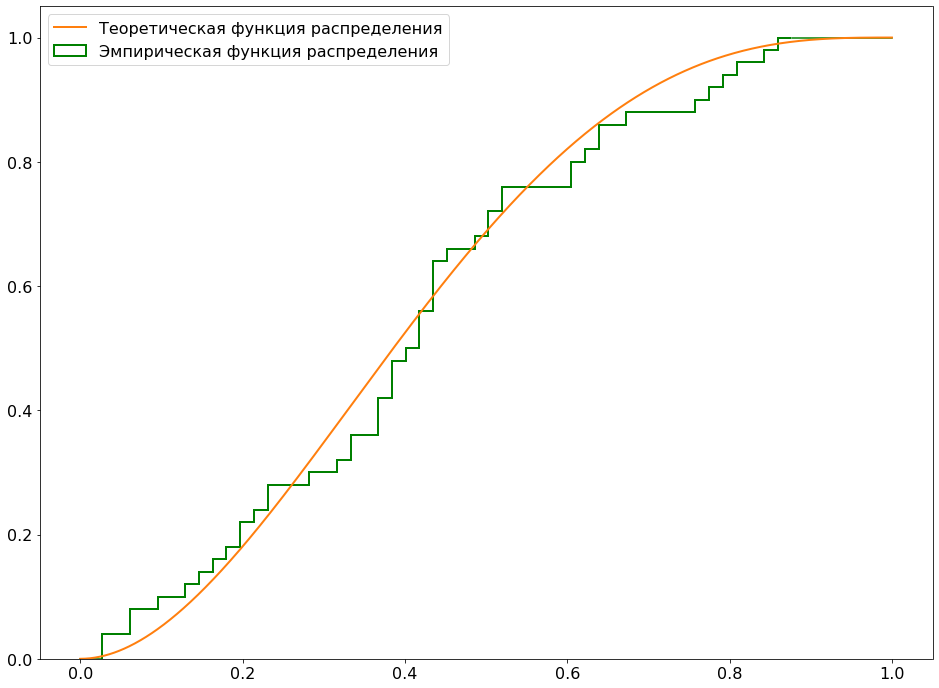

In [26]:
draw_generated_beta(2, 3, 50)

## Источники

[1] Lowell Observatory. URL: https://asteroid.lowell.edu/main/astorb

[2] Ch. Walk. Hand-book on statistical distributions for experimentalists